##  Импортируем все необходимые библиотеки

In [44]:
import cv2
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import json
from PIL import Image
from glob import glob

from lib import *

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from tensorflow.keras import backend as K

import tensorflow as tf

import imgaug as ia
import imgaug.augmenters as iaa

# Установим параметры изображений
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

# Определим пути к изображениям и их маскам
TRAIN_PATH = './train/images/'
MASK_PATH = './train/images/coco_annotations.json'
MASK_PATH = './train/images/'
TEST_PATH = './real_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# Имя сабмита по умолчанию
sub_file_name = 'submission.csv'

In [45]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 12) # установим стандратный размер графиков

##  Анализ данных

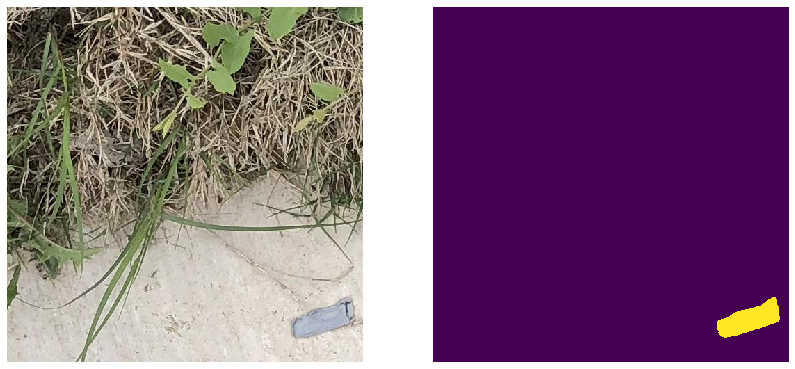

In [46]:
# посмотрим на данные
path = "./train/"
images = os.listdir(f"{path}/images")
annotations = json.load(open(f"{path}/coco_annotations.json", "r"))
img_id = int(np.random.choice(images).split(".")[0])

img = np.array(Image.open(f"{path}/images/{img_id:08}.jpg"))
mask = get_mask(img_id, annotations)
show_img_with_mask(img, mask)

In [52]:
# Получим тренировочные и тестовые ids
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [55]:
# Попробуем нормализовать данные из train и test
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 17), dtype=np.bool)

train_image_id = []
test_image_id = []

print('Предобработка тренировочных данных ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    train_image_id.append(id_)
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.jpg')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + MASK_PATH))[2]:
        
        object_class = int(mask_file[-6:-4])
        mask_ = imread(path + MASK_PATH)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        Y_train[n][:,:,object_class] = np.squeeze(mask_)

    Y_train[n][:,:,16] = np.logical_not(np.max(Y_train[n][:,:,:16], axis=2))

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []

print('Предобработка тестовых данных ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    test_image_id.append(id_)
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.jpg')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

Предобработка тренировочных данных ... 


0it [00:00, ?it/s]

Предобработка тестовых данных ... 



0it [00:00, ?it/s]


## Реализуем сеть U-Net

In [48]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

In [49]:
# Реализуем кодировщик
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)

p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)

p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.1) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)

p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.1) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)

p4 = MaxPooling2D((2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.1) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

In [50]:
# Реализуем декодировщик
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.2) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1])
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.2) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)